In [ ]:
import numpy as np
from scipy import ndimage as nd
import matplotlib.pyplot as plt

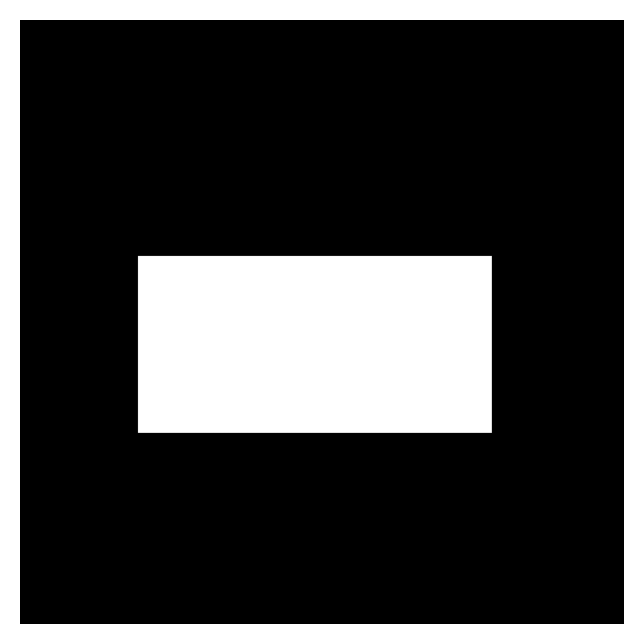

In [ ]:
y_size, x_size = 1024, 1024
image = np.zeros((y_size, x_size))
image[400:700, 200:800] = 1
plt.figure(dpi=200)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def generate_rigid_matrix(xt, yt, rot):
  rot = np.radians(rot)
  rigid_matrix = np.array([[np.cos(rot), -np.sin(rot), xt ],
                           [np.sin(rot), np.cos(rot), yt],
                           [0, 0, 1]
                           ])
  return rigid_matrix

In [ ]:
rigid_matrix = generate_rigid_matrix(100, 150, 0)
print(rigid_matrix)

[[  1.  -0. 100.]
 [  0.   1. 150.]
 [  0.   0.   1.]]


In [ ]:
def center_matrix(transform, shape):
  x_origin = (shape[1] - 1) / 2
  y_origin = (shape[0] - 1) / 2
  a = np.array([
    [1, 0, x_origin],
    [0, 1, y_origin],
    [0, 0, 1],     
  ])
  centered_matrix = a @ transform @ np.linalg.inv(a) 
  return centered_matrix

# print(center_matrix(rigid_matrix, (100, 100)))

def rigid_dot(grid_x, grid_y, transform):
  """
  x' = transform @ x -> 3x3 @ 3x1
  x = [x, y, 1]
  """
  x = [grid_x.flatten(), grid_y.flatten(), np.ones(np.prod(grid_x.shape))]
  x = transform @ x
  transformed_grid_x = x[0, :].reshape(grid_x.shape)
  transformed_grid_y = x[1, :].reshape(grid_y.shape)
  return transformed_grid_x, transformed_grid_y

def rigid_transform(image, transform):
  """
  1) Dokonac zmiany bazy macierzy transformacji w taki sposob, aby rotacja byla wzgledem srodka obrazu
  2) Dokonac transformacji wszystkich koordynatow obrazu wejsciwego korzystajac z macierzy z punktu 1)
  3) Dokonac interpolacji (np. liniowej) w nowych punktach obrazu <- map_coordinates z nd
  """
  transform = center_matrix(transform, image.shape)
  grid_x, grid_y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
  grid_x_tr, grid_y_tr = rigid_dot(grid_x, grid_y, transform)
  transformed_image = nd.map_coordinates(image, [grid_y_tr, grid_x_tr], order=1)
  return transformed_image

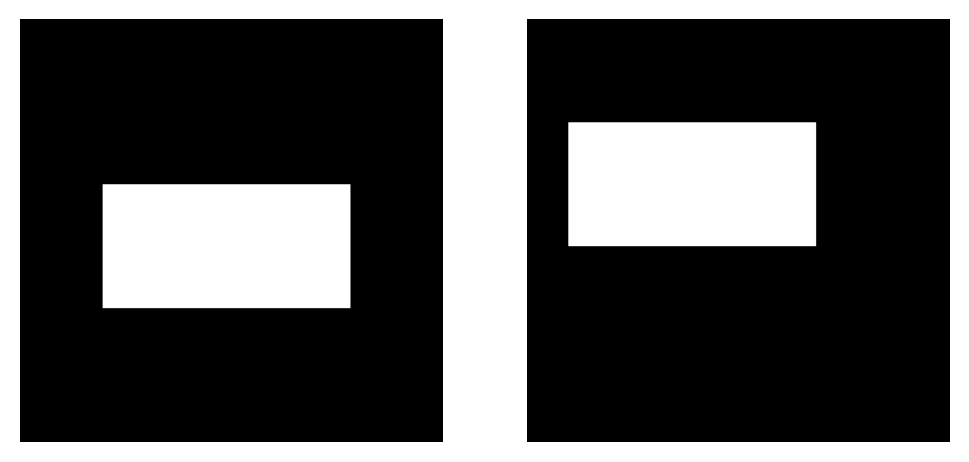

In [ ]:
transformed_image = rigid_transform(image, rigid_matrix)

plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def interpolate_2d(image, grid_x, grid_y):
  img_y, img_x = image.shape[0], image.shape[1]
  new_img = np.zeros([img_y, img_x])

  grid_x =grid_x.ravel()
  grid_y= grid_y.ravel()

  for i in grid_y:
    for j in grid_x:

      y_up, y_down = np.int(np.floor(i)), np.int(np.floor(i)+ 1)
      x_left, x_right = np.int(np.floor(j)), np.int(np.floor(j) + 1)

      a = image[y_up, x_left]
      b = image[y_up, x_right]
      c = image[y_down, x_left]
      d = image[y_down, x_right]

      w_x = j - x_left
      w_y = i - y_up

      wA = (1 - w_x) * (1 - w_y)
      wB =  w_x * (1 - w_y)
      wC = w_y * (1 - w_x)
      wD = w_x * w_y

      interpolated_point = a*wA + b*wB + c*wC + d*wD 
      new_img[x_left][y_up] = interpolated_point
  return new_img